In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
years = [2009,2010,2011,2012,2013,2014,2015]
path ='/public/npatil4/dataMining/data/daily/combined_wide/'
files = [path+'combined_wide_'+str(year)+'.csv' for year in years]

In [3]:
data = [pd.read_csv(file_name,sep='|') for file_name in files]

In [4]:
[df.shape for df in data]

[(148428, 18),
 (160416, 18),
 (157975, 18),
 (168291, 18),
 (184197, 18),
 (196085, 18),
 (206363, 18)]

In [5]:
data= pd.concat(data, ignore_index=True)

In [6]:
data['DateLocal'] = pd.to_datetime(data.DateLocal)
data['year'] = data.DateLocal.dt.year
data['weekNo'] = data.DateLocal.dt.week
data['Weekday'] = data.DateLocal.dt.weekday

In [7]:
data.head(2).transpose()

,0,1
DateLocal,2009-01-01 00:00:00,2009-01-01 00:00:00
CityName,Aberdeen,Adjuntas
CountyName,Brown,Adjuntas
StateName,South Dakota,Puerto Rico
Latitude,45.4625,18.17538
Longitude,-98.48611,-66.72599
Barometricpressure,NaN,NaN
Carbonmonoxide,NaN,NaN
DewPoint,NaN,NaN
NitrogenDioxide,NaN,NaN


In [8]:
data_missing = data.isnull()

In [9]:
data_missing_count = data_missing.ix[:,6:-4].apply(sum,1).groupby([data.CountyName,
                                                                   data.CityName]
                                                                 ).mean()
data_missing_count = pd.DataFrame(data_missing_count[data_missing_count>=8]).reset_index()

In [10]:
data_pol = data.ix[:,:-4].groupby([
       'DateLocal',
       'CityName', 'CountyName',
       'Latitude','Longitude'],
        as_index=False).mean()


In [11]:
data_model = pd.read_csv('../data/daily/combined_wide/combined_wide_all_filled_si.txt',
                         sep='|')

In [12]:
data_model['CityName'] = data_pol.CityName
data_model['CityName'] = data_model.CityName.astype('category')
data_model['date'] = data_pol.DateLocal
data_model['weekNo'] = data_model.date.dt.weekofyear
data_model['weekNo'] = data_model.weekNo.astype('category')
data_model['yearNo'] = data_model.date.dt.year
data_model['yearNo'] = data_model.yearNo.astype('category')
data_model['monthNo'] = data_model.date.dt.month
data_model['monthNo'] = data_model.monthNo.astype('category')
data_model['pm_mean_month'] = data_model.PM.groupby([data_model.CityName,
                                                     data_model.yearNo,
                                                     data_model.monthNo]).transform('mean')
data_model['pm_mean_weekNo'] = data_model.PM.groupby([data_model.CityName,
                                                     data_model.yearNo,
                                                     data_model.weekNo]).transform('mean')
data_model['PM'] = pd.Series([0]).append(data_model.PM[:-1]).reset_index(drop=True)

In [13]:
RandomState = 42
train = data_model.sample(frac=0.7,random_state=RandomState)
test = data_model[~(data_model.index.isin(train.index))]

In [14]:
columns = ['Carbonmonoxide',
           'DewPoint',
           'NitrogenDioxide',
           'OutdoorTemperature',
           'Ozone',
           'RelativeHumidity',
           'Sulfurdioxide',
           'weekNo',
           'monthNo',
           'pm_mean_month',
           'pm_mean_weekNo']

In [15]:
X = train[columns]
y = train.PM

#### XG Boost

In [16]:
xgb = GradientBoostingRegressor()
xgb.fit(X,y, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

/software/python/2.7.10/b1/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


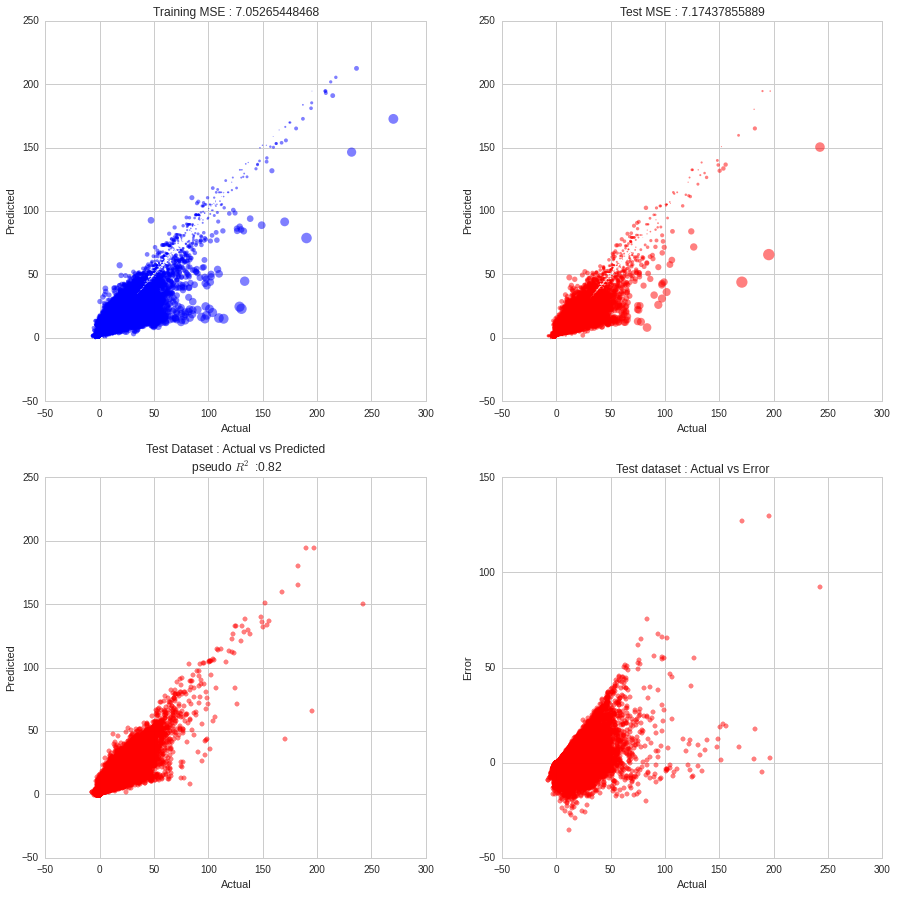

In [17]:
path_plot = '../plots/Matrix_completion_results_'


x_train = train.PM
y_train = xgb.predict(X)
error_train = x_train-y_train

x_test = test.PM
y_test = xgb.predict(test[columns])
error_test = x_test-y_test

q = pd.DataFrame({  'x':x_test,
                    'y':y_test,
                    'error_test':error_test
                }).reset_index(drop=True)
q = q.sort(['x'],inplace=False)

xgb_rSquared = round(explained_variance_score(x_test,y_test),3)

mice_plot = sns.plt.figure(figsize=(15,15))
sns.set_style('whitegrid')


mice_plot.add_subplot(221)
sns.plt.scatter(x_train,
                y_train,
                linewidths=0.0,
                s = abs(error_train),
                c='blue',
                alpha=0.5)
sns.plt.title('Training MSE : '+str(mean_squared_error(x_train,y_train)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(222)
sns.plt.scatter(x_test,
                y_test,
                linewidths=0.0,
                s = abs(error_test),
                c='red',
                alpha=0.5)
sns.plt.title('Test MSE : '+str(mean_squared_error(x_test,y_test)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(223)
sns.plt.scatter(x_test,
                y_test,
                alpha=0.5,
                color='r')
sns.plt.title('Test Dataset : Actual vs Predicted \n pseudo $R^2$ :'+str(xgb_rSquared))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(224)
sns.plt.scatter(x_test,
                error_test,
                alpha=0.5,
                color='r')
sns.plt.title('Test dataset : Actual vs Error')
sns.plt.xlabel('Actual')
sns.plt.ylabel('Error')


plt.savefig(path_plot+'si_month_week_aggregates_xgb.png',dpi = 750)

In [18]:
model_vars = pd.DataFrame(
             {'variable':columns,
              'importance':xgb.feature_importances_})

model_vars.sort('importance',ascending=False,inplace=True)
model_vars.head()

,importance,variable
1,0.211567,DewPoint
6,0.205784,Sulfurdioxide
0,0.179744,Carbonmonoxide
10,0.142658,pm_mean_weekNo
2,0.121109,NitrogenDioxide


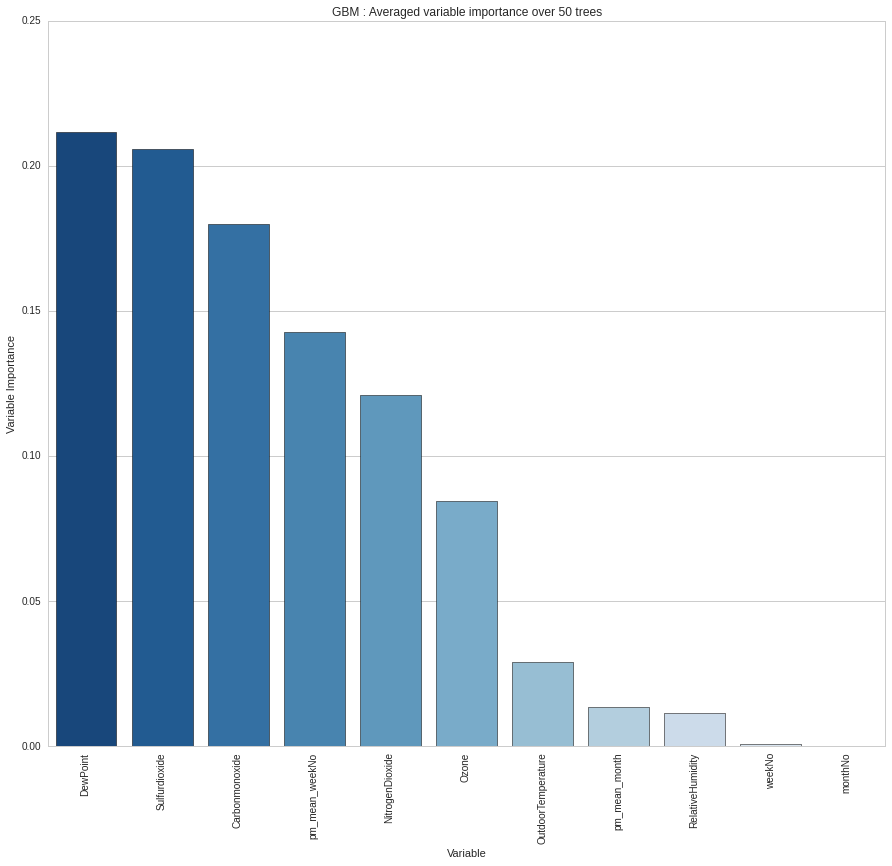

In [19]:
sns.plt.figure(figsize=(15,13))


sns.barplot(y='importance',
            x='variable',
            data=model_vars,
            palette=sns.color_palette("Blues_r",
                                      n_colors=len(model_vars.variable)),
            linewidth=0.5)
sns.plt.xticks(rotation=90)
sns.plt.xlabel('Variable')
sns.plt.ylabel('Variable Importance')
sns.plt.title('GBM : Averaged variable importance over 50 trees')

sns.plt.savefig('../plots/VariableImportance_xgb.png',
                dpi=500)